In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('AAPL.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,03-01-2012,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
1,04-01-2012,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2,05-01-2012,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
3,06-01-2012,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
4,09-01-2012,60.785713,61.107143,60.192856,60.247143,52.061932,98506100


In [4]:
df.shape

(2011, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2011 non-null   object 
 1   Open       2011 non-null   float64
 2   High       2011 non-null   float64
 3   Low        2011 non-null   float64
 4   Close      2011 non-null   float64
 5   Adj Close  2011 non-null   float64
 6   Volume     2011 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 110.1+ KB


In [6]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [7]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

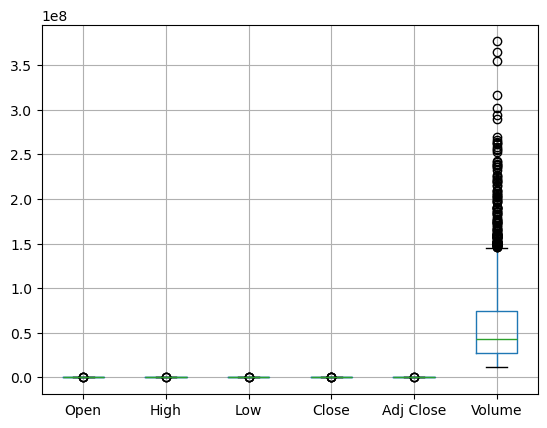

In [9]:
df.boxplot()
plt.show()

In [10]:
def outlier_capping(df,column):
    Q1= df[column].quantile(0.25)
    Q3= df[column].quantile(0.75)
    IQR=Q3-Q1
    lower_bound= Q1-1.5*IQR
    upper_bound= Q3+1.5*IQR
    df[column]= df[column].apply(lambda x: lower_bound if x<lower_bound else upper_bound if x>upper_bound else x)
for col in df.select_dtypes(['int','float']).columns:
    outlier_capping(df,col)

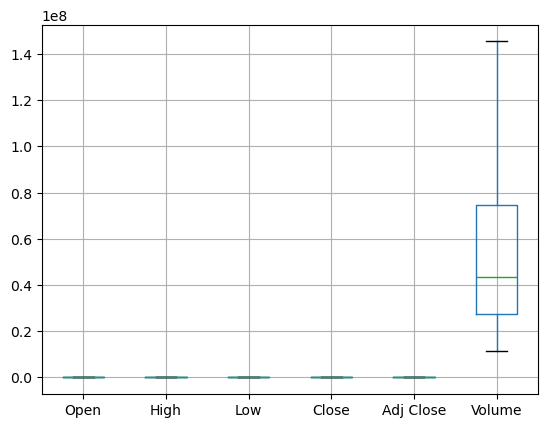

In [11]:
df.boxplot()
plt.show()

Sanitized outliers

### Correlation Heatmap

Let's visualize the correlation between the numerical features in the DataFrame. A heatmap helps in understanding which features are highly correlated with each other.

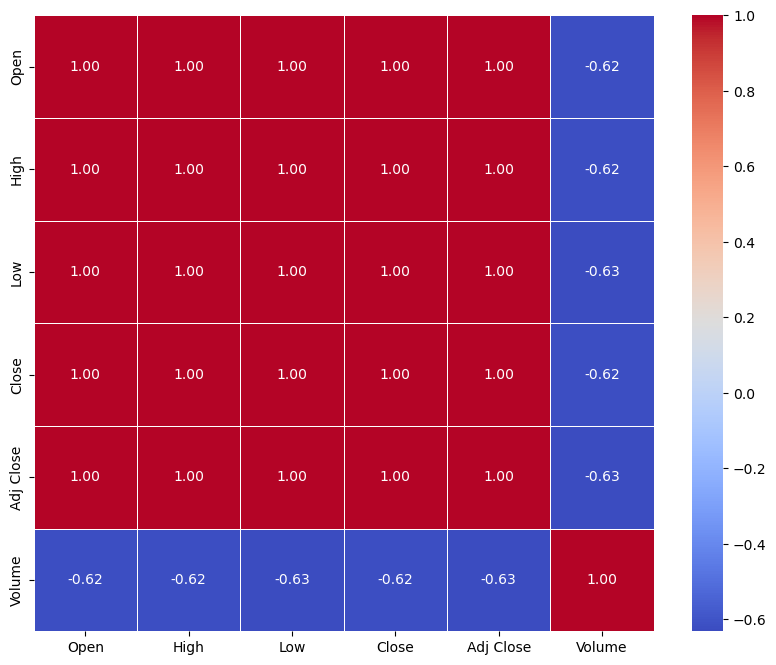

In [12]:

numeric_df = df.select_dtypes(include=np.number)
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

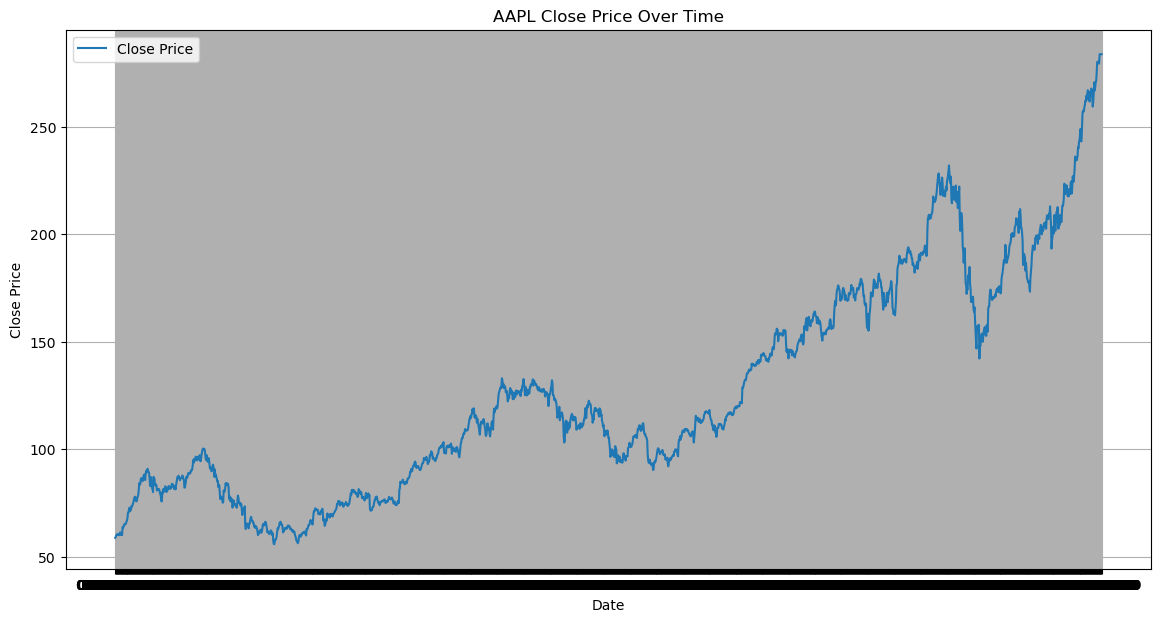

In [13]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.title('AAPL Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

### Identifying Trends

We will visualize the 'Close' price over time and use a moving average to identify trends.

In [14]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

### LSTM Model Implementation

To build and train an LSTM (Long Short-Term Memory) neural network, we need to preprocess our time-series data. This involves selecting the target variable, normalizing the data, and creating sequences (input-output pairs) for the LSTM model to learn from.

In [15]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Select the 'Close' price for prediction
data = df['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create sequences for LSTM
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

# Define the look-back period (number of previous time steps to use as input)
look_back = 60 # Using 60 days of historical data to predict the next day's close price

X, y = create_sequences(scaled_data, look_back)

print(f"Shape of X (features): {X.shape}")
print(f"Shape of y (target): {y.shape}")

Shape of X (features): (1951, 60)
Shape of y (target): (1951,)


Now that the data is prepared, let's build the LSTM model. We'll use a sequential Keras model with LSTM layers.

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size,:], X[train_size:len(X),:]
y_train, y_test = y[0:train_size], y[train_size:len(y):]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()

C:\ExcelR\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

With the model defined, we can now train it using our prepared training data and then evaluate its performance on the test set.

In [17]:
from sklearn.metrics import mean_squared_error

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_inverse, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_inverse, test_predict))

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Calculate accuracy in percentage (e.g., within 5% tolerance)
def calculate_percentage_accuracy(y_true, y_pred, tolerance_percent=5):
    # Calculate the absolute percentage error
    percentage_error = np.abs((y_true - y_pred) / y_true) * 100
    # Count predictions within the tolerance
    correct_predictions = np.sum(percentage_error <= tolerance_percent)
    # Calculate accuracy
    accuracy = (correct_predictions / len(y_true)) * 100
    return accuracy

train_accuracy = calculate_percentage_accuracy(y_train_inverse, train_predict)
test_accuracy = calculate_percentage_accuracy(y_test_inverse, test_predict)

print(f'Train Accuracy (within 5% tolerance): {train_accuracy:.2f}%')
print(f'Test Accuracy (within 5% tolerance): {test_accuracy:.2f}%')

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 9.1108e-04 - val_loss: 8.4861e-04
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 7.8670e-04 - val_loss: 0.0014
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.6686e-04 - val_loss: 0.0016
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 6.7232e-04 - val_loss: 8.9750e-04
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.4161e-04 - val_loss: 7.6330e-04
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 6.2453e-04 - val_loss: 9.6144e-04
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5.7314e-04 - val_loss: 0.0021
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.6970e-04 - val_loss: 7.6446e-04
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5.4373e-04 - val_loss: 0.0013
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5.6266e-04 - val_loss: 7.4128e-04

Finally, let's visualize the actual versus predicted prices to see how well the model performs.

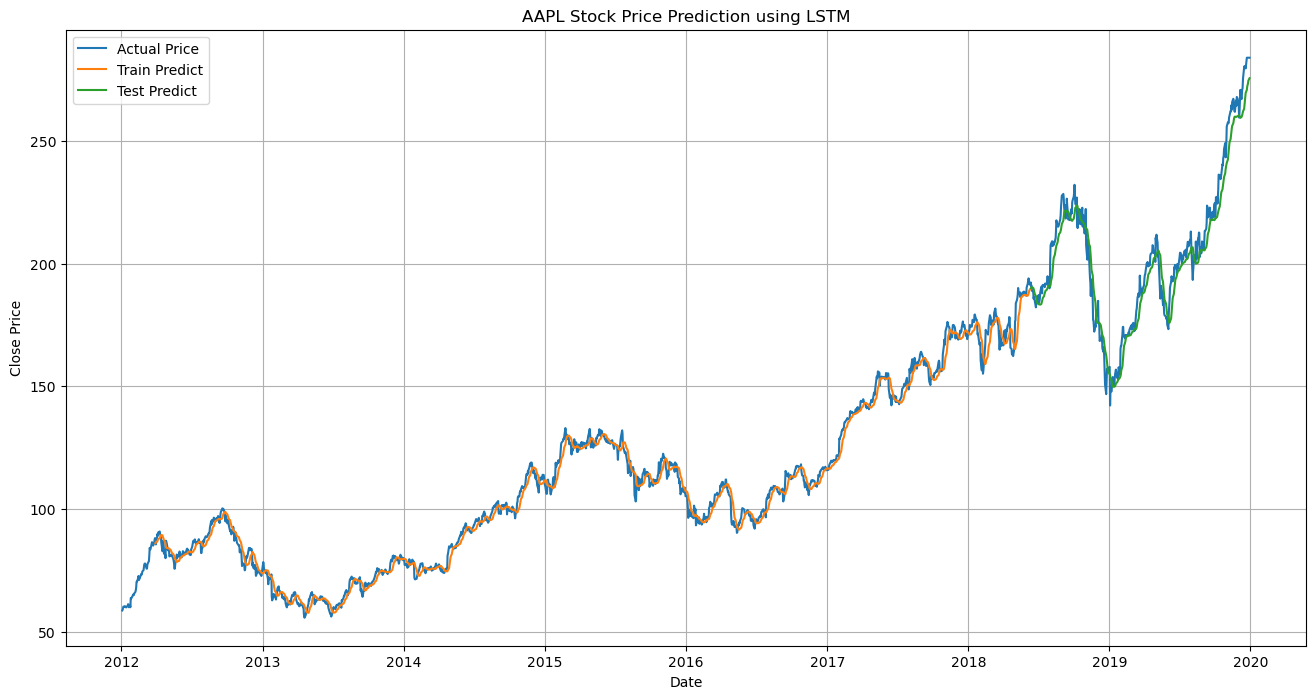

In [18]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(df['Date'], scaler.inverse_transform(scaled_data), label='Actual Price')

# Shift train predictions for plotting
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict
plt.plot(df['Date'], train_predict_plot, label='Train Predict')

# Shift test predictions for plotting
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back):len(scaled_data), :] = test_predict
plt.plot(df['Date'], test_predict_plot, label='Test Predict')

plt.title('AAPL Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Save trained model
model.save("aapl_lstm_model.h5")
print("Model saved as aapl_lstm_model.h5")

# Save scaler
import joblib
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved as scaler.pkl")


Model saved as aapl_lstm_model.h5
Scaler saved as scaler.pkl
